Load all modules and libraries

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Lambda, Dense, Input, Dot
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Model

from matplotlib import pyplot
print(keras.__version__)

2.2.4-tf


In [2]:
from arcs import Arcs
from data_generator import DataGenerator


Initialize ARCS class with three critical parameters

In [3]:
model_file = "f:/Models/Lemma_DBOW_2_doc2vec_trec_d1000_n5_w8_mc20_t12_e10_dbow.model"
topics_folder = "f:/Runs/topics/"
qrels_folder = "f:/Runs/qrels/"

arcs = Arcs(model_file=model_file, qrels_path=qrels_folder, topics_path=topics_folder)

Generate training set from Qrels topics and documents

In [4]:
arcs.create_training_set(shuffle=True)
ts_doc_list = arcs.get_docvecs()
ts_topic_list = arcs.get_topicvecs(use_topic_vector=True, include_title=True, include_desc=False, include_narr=False)
ts_label_list = arcs.get_labels()
# arcs.init_topic_vecs()
data_generator = DataGenerator(ts_doc_list, ts_topic_list, ts_label_list, batch_size=64, dim=1000)

Create training SBM (Searching Behavior Memory) model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
doc_vec (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
SBM (Dense)                     (None, 151574)       151574000   doc_vec[0][0]                    
__________________________________________________________________________________________________
l2_norm (Lambda)                (None, 151574)       0           SBM[0][0]                        
__________________________________________________________________________________________________
target_vec (InputLayer)         [(None, 151574)]     0                                            
______________________________________________________________________________________________

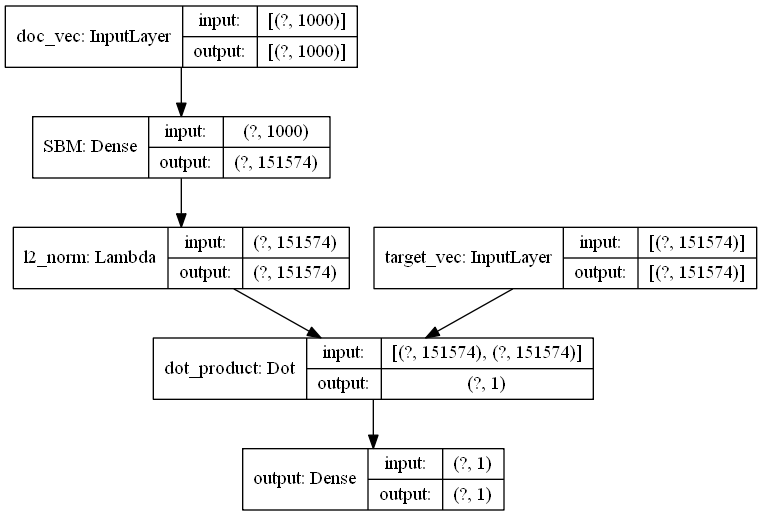

In [5]:
embedding_dim = arcs.embedding_dim
# embedding_dim = 1000
vocab_size = arcs.vocab_size
# vocab_size = 150000

docvec_input = Input((embedding_dim,), name='doc_vec')
target_vec = Input((vocab_size,), name='target_vec')

sbm = Dense(vocab_size, use_bias=False, name='SBM')(docvec_input)
predict_vec = Lambda(lambda x:l2_normalize(x, axis=-1), name='l2_norm')(sbm)
# predict_vec = Reshape((vocab_size, 1), name='predict_vec')(l2_normed)
dot_product = Dot(axes=1, normalize=False, name='dot_product')([predict_vec, target_vec])
# dot_product = Reshape((1,), name='')(dot_product)
output = Dense(units=1, activation='sigmoid',name='output')(dot_product)

model = Model(inputs=[docvec_input, target_vec], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

Create keyword prediction SBM model

In [ ]:
keyword_model = Model(inputs=docvec_input, outputs=predict_vec)
keyword_model.summary()

Create retrieval SBM model

In [ ]:
cos_similarity = Dot(axes=1, normalize=True, name='cos_similarity')([predict_vec, target_vec])
retrieval_model = Model(inputs=[docvec_input, target_vec], outputs=cos_similarity)

retrieval_model.summary()
keras.utils.plot_model(model, show_shapes=True)

Train the SBM model

In [6]:
history = model.fit(x=data_generator, epochs=10)

  ...
    to  
  ['...']
Train for 1431 steps
Epoch 1/10
1431/1431 [==============================] - 222s 155ms/step - loss: 0.5813 - accuracy: 0.6969

Save training, keyword prediction and document retrieval SBM models

In [ ]:
sbm_training_model_file = "f:/Models/NN/sbm_training.tf"
sbm_keyword_model_file = "f:/Models/NN/sbm_keyword.tf"
sbm_retrieval_model_file = "f:/Models/NN/sbm_predict.tf"

model.save(sbm_training_model_file)
keyword_model.save(sbm_keyword_model_file)
retrieval_model.save(sbm_retrieval_model_file)

Performance analysis

In [ ]:
pyplot.plot(history.history['accuracy'], label='train')
# pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
